# Allison Vincent
GEOS 505
Final Project

# Introduction

The ability to observe and track changes in snow-covered area (SCA) is important for a variety of reasons. Water availability in many locations is dependent on the amount of precipitation that falls in winter as snow. This is especially relevant in many mountain watersheds where the melting of winter snowpack sustains water needs locally and in lower elevations during the dry summer months. To understand trends in past water availability and to forecast future hydrologic behavior it is important to be able to isolate the behavior of specific input variables, such as SCA, to the larger system.

One of the ways SCA can be observed is through remote sensing. Remote sensing is ideal since it can collect data over wide ranges of time and area, and often in locations that are too difficult or dangerous for human access. The remote sensing methods that were used to analyze SCA in this project come from NASA’s MODerate resolution Imaging Spectroradiometer (MODIS) sensor. This sensor captures spectral radiance in the visible and infrared spectrums and can be processed in a variety of ways to determine SCA for a location. The objective of this project was to analyze two MODIS datasets, find the computed SCA results for each, and then peform a comparison of the two to investigate the similarities or differences of their representation of SCA. 

The study area used in this analysis is the East River Watershed in the southern Rocky Mountains of western Colorado. This watershed is approximately 300 km^2 in area and has a topographic relief of 1420m. The East River Watershed is a good representation of a typical mountain watershed in the western United States, and therefore is an ideal area for comparing snow detection datasets. 


# Data

## Choosing dates for analysis

Dates were chosen for analysis by first looking at the NRCS’s SNOTEL data for the Crested Butte sensor location (National Climatic Data Center) (see Jupyter notebook for GEOS 505 Assignment 1 on Github). The year 2014 was chosen because it was slightly above average in total snow water equivalent (SWE) amounts, and the assumption was made that there would be an adequate amount of snow in the higher elevations during the spring warm-up season to compare to snow-free areas in the lower elevations of the watershed. Two late snow season dates, May 1, 2014 and June 15, 2014, were chosen for specific analysis to clearly see differences in SCA caused by snow melt over the course of one season, and also because these dates had as little cloud cover as possible. 


## MODSCAG Data

MODSCAG stands for MODIS Snow Covered-Area and Grain Size retrieval algorithm (Painter, et al., 2009). These data are available through the Snow Data Systems Portal, which is managed by NASA’s Jet Propulsion Laboratory. It uses surface reflectance to calculate per pixel fractional snow cover, grain size, and albedo through the use of spectral libraries with endmembers generated by modeling, laboratory, and field methods. These data have a spatial resolution of 500m and a daily temporal resolution. They are available in Geotiff format.



## MCD43A4 Data

MCD43A4 data is available through the Land Processes Distributed Active Archive Center (LP DAAC), which is managed by NASA and the USGS. It uses a bidirectional reflectance distribution function to estimate albedo and spectral reflectance in visible and infrared Bands 1-7 (Schaaf and Wang, 2015). These data have a spatial resolution of 500m and a daily temporal resolution. They are available in .hdf format.

SCA can be determined from the MCD43A4 dataset by calculating the Normalized Difference Snow Index (NDSI). NDSI is a spectral band ratio that takes advantage of the spectral reflectance of snow and how it varies in the visible and short-wave infrared spectrums. 



# Methods

## Reprojecting MODSCAG Data 

Before fractional snow cover for the East River watershed can be determined, the data must first be reprojected from its original sinusoidal projection to a more localized projection (in this case UTM 13 WGS84), and clipped to the watershed boundary.

In [1]:
import gdal
import numpy as np
import matplotlib.pyplot as plt

In [2]:
filename = r"C:/Users/Allison and Brian/Documents/Research/MODSCAG_Data/1.13.2014/MOD09GA.A2014013.h09v05.005.2014015123811.snow_fraction.tif"
input_raster = gdal.Open(filename)
output_raster = r"C:/Users/Allison and Brian/Documents/Research/MODSCAG_Data/1.13.2014/MOD09GA.1132014.reproject.tif"
gdal.Warp(output_raster,input_raster,dstSRS='+proj=utm +zone=13 +datum=WGS84')

<osgeo.gdal.Dataset; proxy of <Swig Object of type 'GDALDatasetShadow *' at 0x000001965B1DC9F0> >

In [3]:
grid_filename = "C:/Users/Allison and Brian/Documents/Research/MODSCAG_Data/1.13.2014/MOD09GA.1132014.reproject.tif"

In [4]:
gfid = gdal.Open(grid_filename)
data = gfid.ReadAsArray()
data = np.float64(data)

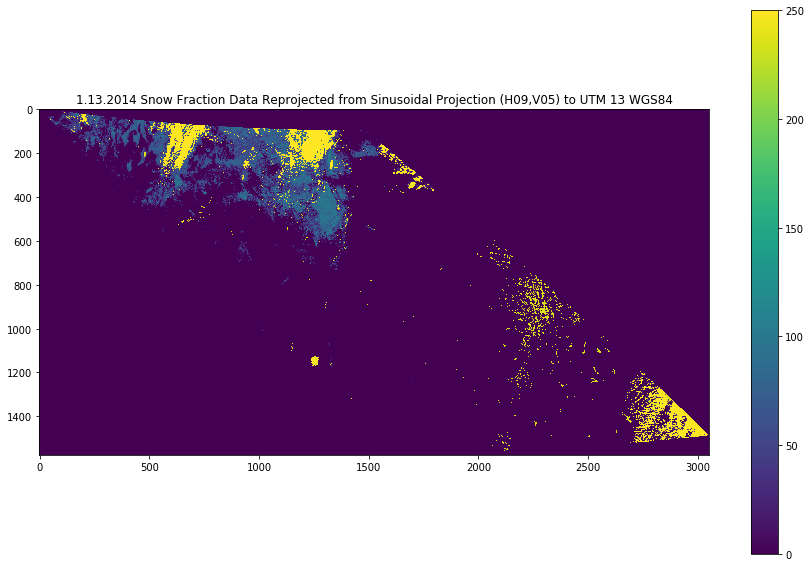

In [5]:
plt.figure(figsize=(15,10))
plt.imshow(data)
plt.title('1.13.2014 Snow Fraction Data Reprojected from Sinusoidal Projection (H09,V05) to UTM 13 WGS84')
plt.colorbar()

The above code was repeated to reproject h09 v05 imagery from dates 5.1.2014 and 6.5.2014.

## Reprojecting MCD43A4 Data

Similar to MODSCAG, this dataset must also be reprojected from its original sinusoidal projection to a more localized projection (also UTM 13 WGS84), and clipped to the watershed boundary.

MCD43A4 data is available through LP DAAC in .hdf file format. Because of this, the free HEG-HDF tool was used for reprojection since it has the ability to not only reproject the image, but also to simultaneously convert the file into Geotiff format. The decision to have both datasets in the same Geotiff format was made for ease of analysis.

## Subsetting MODSCAG Data 

Below MODSCAG data is clipped to the East River watershed boundary.

### 5.1.2014 Data

In [6]:
from osgeo import gdalnumeric, ogr
from PIL import Image, ImageDraw

In [7]:
input_raster = "C:/Users/Allison and Brian/Documents/Research/MODSCAG_Data/5.1.2014/MODSCAG_EastRiver_SnowFraction_5.1.2014_Reproject.tif"
shp_path = 'C:/Users/Allison and Brian/Documents/Research/East River/'
shp_file = "EastRiver_Project"
output_raster = "MODSCAG.5.1.Clip"

In [8]:
def imageToArray(i):
    a = gdalnumeric.frombuffer(i.tobytes(),'b')
    a.shape = i.im.size[1], i.im.size[0]
    return a

In [9]:
def world2Pixel(geoMatrix, x,y):
    ulX = geoMatrix[0]
    ulY = geoMatrix[3]
    xDist = geoMatrix[1]
    yDist = geoMatrix[5]
    rtnX = geoMatrix[2]
    rtnY = geoMatrix[4]
    pixel = int((x-ulX) / xDist)
    line = int((y - ulY) / yDist)
    return (pixel, line)

In [10]:
# Load the source data as a gdalnumeric array
srcArray = gdalnumeric.LoadFile(input_raster)

In [11]:
# Load as a gdal image to get geotransform (world file) info
scrImage = gdal.Open(input_raster)
geoTrans = scrImage.GetGeoTransform()


In [12]:
shapef = ogr.Open(shp_path+shp_file+'.shp')
lyr = shapef.GetLayer(shp_file)
print(lyr.GetExtent())

poly = lyr.GetNextFeature()

(316163.46685506613, 348499.0273751031, 4281026.531395504, 4322442.225625547)


In [13]:
#Convert the layer extent to image pixel coordinates
minX, maxX, minY, maxY = lyr.GetExtent()
ulX, ulY = world2Pixel(geoTrans, minX, maxY)
lrX, lrY = world2Pixel(geoTrans, maxX, minY)

In [14]:
# Calculate the pixel size of the new image
pxWidth = int(lrX - ulX)
pxHeight = int(lrY - ulY)

In [15]:
# Multi-band image
clip = srcArray[ulY:lrY, ulX:lrX]

In [16]:
# Create a new geomatrix for the image
geoTrans = list(geoTrans)
geoTrans[0] = minX
geoTrans[3] = maxY

In [17]:
# Map points to pixels for drawing 
points = []
pixels = []
geom = poly.GetGeometryRef()
pts = geom.GetGeometryRef(0)
for p in range(pts.GetPointCount()):
  points.append((pts.GetX(p), pts.GetY(p)))
for p in points:
  pixels.append(world2Pixel(geoTrans, p[0], p[1]))
rasterPoly = Image.new("L", (pxWidth, pxHeight), 1)
rasterize = ImageDraw.Draw(rasterPoly)
rasterize.polygon(pixels, 0)
mask = imageToArray(rasterPoly)  

In [18]:
clip = gdalnumeric.choose(mask, \
    (clip, 255)).astype(gdalnumeric.uint8)

In [19]:
gdalnumeric.SaveArray(clip, "%s.tif" % output_raster, \
    format = "GTiff", prototype = input_raster)

<osgeo.gdal.Dataset; proxy of <Swig Object of type 'GDALDatasetShadow *' at 0x000001965C5EFA80> >

In [20]:
grid_filename = 'C:/Users/Allison and Brian/Documents/Research/MODSCAG_Data/5.1.2014/MODSCAG.5.1.Clip.tif'

In [21]:
gfid = gdal.Open(grid_filename) # file identifier, map to where the data is in the computer
data1 = gfid.ReadAsArray()   # read data as an array of integers
data1 = np.float64(data1) # convert data from integer to float 
data1[data1 >= 101] = np.nan

print(data1.shape)

(55, 43)


<Figure size 432x288 with 0 Axes>

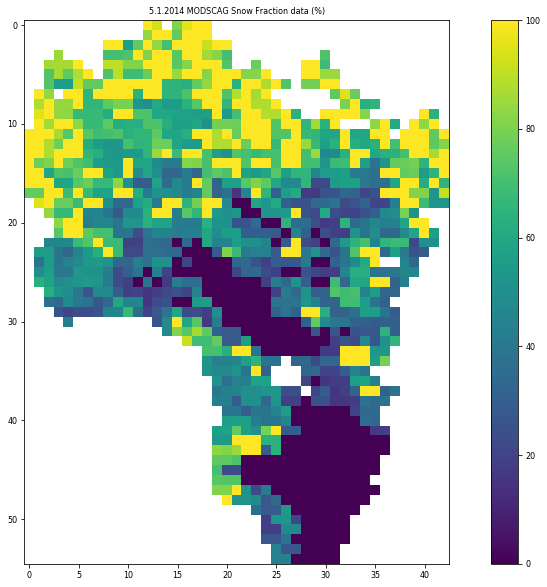

In [58]:
fig1 = plt.figure()
MOD_May1 = plt.figure
plt.figure(figsize=(15,10))
plt.title('5.1.2014 MODSCAG Snow Fraction data (%)')
plt.imshow(data1)
plt.colorbar()

In [65]:
# Make a snow map
SnowMap1 = np.zeros((data1.shape))

NO_DATA_const = -9999.0

SF_threshold = 40
SnowMap1[np.isnan(data1)] = NO_DATA_const
SnowMap1[~np.isnan(data1)] = data1[~np.isnan(data1)]
SnowMap1[(SnowMap1 >= SF_threshold) & (SnowMap1 != NO_DATA_const)] = 100
SnowMap1[(SnowMap1 < SF_threshold) & (SnowMap1 != NO_DATA_const)] = 0.0
SnowMap1[SnowMap1 == NO_DATA_const] = np.nan

<Figure size 432x288 with 0 Axes>

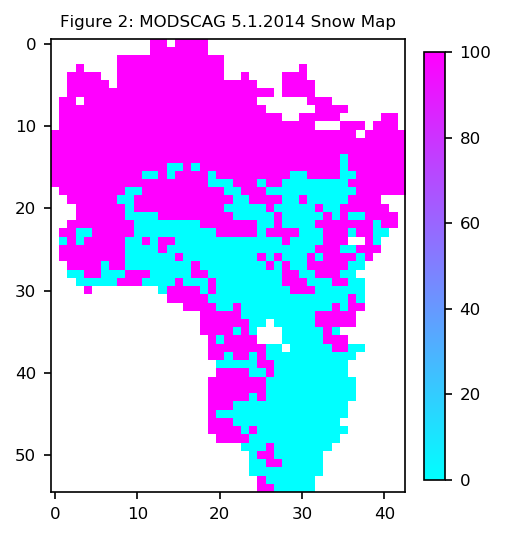

In [66]:
fig2 = plt.figure()
plt.figure(figsize=(4,4), dpi=150)
plt.title('Figure 2: MODSCAG 5.1.2014 Snow Map')
plt.imshow(SnowMap1, cmap='cool')
plt.colorbar(fraction=0.046, pad=0.04)
plt.show()

Pink = snow, Blue = no snow

### 6.15.2014 Data

In [25]:
input_raster = "C:/Users/Allison and Brian/Documents/Research/MODSCAG_Data/6.15.2014/MODSCAG_EastRiver_SnowFraction_6.15.2014_Reproject.tif"
shp_path = 'C:/Users/Allison and Brian/Documents/Research/East River/'
shp_file = "EastRiver_Project"
output_raster = "MODSCAG.6.15.Clip"

In [26]:
def imageToArray(i):
    a = gdalnumeric.frombuffer(i.tobytes(),'b')
    a.shape = i.im.size[1], i.im.size[0]
    return a

def world2Pixel(geoMatrix, x,y):
    ulX = geoMatrix[0]
    ulY = geoMatrix[3]
    xDist = geoMatrix[1]
    yDist = geoMatrix[5]
    rtnX = geoMatrix[2]
    rtnY = geoMatrix[4]
    pixel = int((x-ulX) / xDist)
    line = int((y - ulY) / yDist)
    return (pixel, line)

# Load the source data as a gdalnumeric array
srcArray = gdalnumeric.LoadFile(input_raster)

# Load as a gdal image to get geotransform (world file) info
scrImage = gdal.Open(input_raster)
geoTrans = scrImage.GetGeoTransform()

shapef = ogr.Open(shp_path+shp_file+'.shp')
lyr = shapef.GetLayer(shp_file)
print(lyr.GetExtent())

poly = lyr.GetNextFeature()

#Convert the layer extent to image pixel coordinates
minX, maxX, minY, maxY = lyr.GetExtent()
ulX, ulY = world2Pixel(geoTrans, minX, maxY)
lrX, lrY = world2Pixel(geoTrans, maxX, minY)

# Calculate the pixel size of the new image
pxWidth = int(lrX - ulX)
pxHeight = int(lrY - ulY)

# Multi-band image
clip = srcArray[ulY:lrY, ulX:lrX]

# Create a new geomatrix for the image
geoTrans = list(geoTrans)
geoTrans[0] = minX
geoTrans[3] = maxY

# Map points to pixels for drawing 
points = []
pixels = []
geom = poly.GetGeometryRef()
pts = geom.GetGeometryRef(0)
for p in range(pts.GetPointCount()):
  points.append((pts.GetX(p), pts.GetY(p)))
for p in points:
  pixels.append(world2Pixel(geoTrans, p[0], p[1]))
rasterPoly = Image.new("L", (pxWidth, pxHeight), 1)
rasterize = ImageDraw.Draw(rasterPoly)
rasterize.polygon(pixels, 0)
mask = imageToArray(rasterPoly)  

clip = gdalnumeric.choose(mask, \
    (clip, 255)).astype(gdalnumeric.uint8)

gdalnumeric.SaveArray(clip, "%s.tif" % output_raster, \
    format = "GTiff", prototype = input_raster)



(316163.46685506613, 348499.0273751031, 4281026.531395504, 4322442.225625547)


<osgeo.gdal.Dataset; proxy of <Swig Object of type 'GDALDatasetShadow *' at 0x00000196610AC270> >

Text(0.5,1,'6.15.2014 MODSCAG Snow Fraction data (%)')

<Figure size 432x288 with 0 Axes>

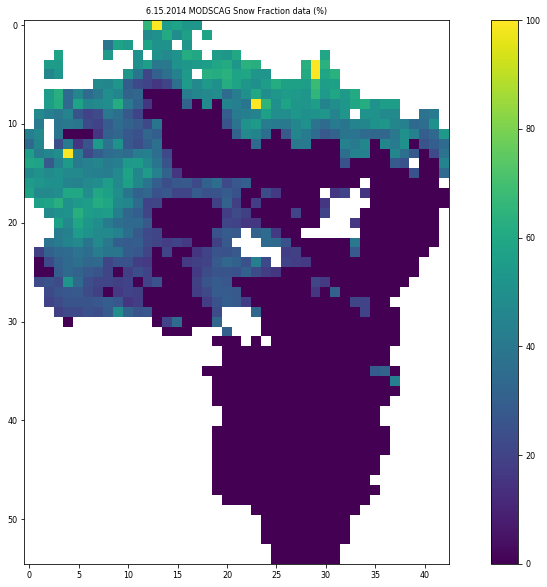

In [59]:
grid_filename = 'C:/Users/Allison and Brian/Documents/Research/MODSCAG_Data/6.15.2014/MODSCAG.6.15.Clip.tif'
gfid = gdal.Open(grid_filename) # file identifier, map to where the data is in the computer
data2 = gfid.ReadAsArray()   # read data as an array of integers
data2 = np.float64(data2) # convert data from integer to float 
data2[data2 >= 101] = np.nan

fig3 = plt.figure()
plt.figure(figsize=(15,10))
plt.imshow(data2)
plt.colorbar()
plt.title('6.15.2014 MODSCAG Snow Fraction data (%)')

<Figure size 432x288 with 0 Axes>

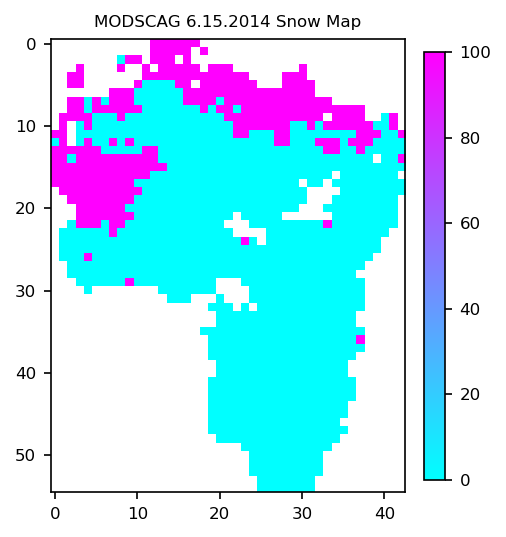

In [67]:
SnowMap2 = np.zeros((data2.shape))

NO_DATA_const = -9999.0

SF_threshold = 40
SnowMap2[np.isnan(data2)] = NO_DATA_const
SnowMap2[~np.isnan(data2)] = data2[~np.isnan(data2)]
SnowMap2[(SnowMap2 >= SF_threshold) & (SnowMap2 != NO_DATA_const)] = 100
SnowMap2[(SnowMap2 < SF_threshold) & (SnowMap2 != NO_DATA_const)] = 0.0
SnowMap2[SnowMap2 == NO_DATA_const] = np.nan

fig4 = plt.figure()
plt.figure(figsize=(4,4), dpi=150)
plt.title('MODSCAG 6.15.2014 Snow Map')
plt.imshow(SnowMap2, cmap='cool')
plt.colorbar(fraction=0.046, pad=0.04)
plt.show()

Pink = snow, Blue = no snow

## Subsetting MCD43A4 Data

Note: The above code was attempted for subsetting and clipping the MCD43A4 data unsuccessfully. In the interest of time, after much troubleshooting, the dataset was clipped to the East River watershed boundary in ArcMap and used here instead.

## Calculating NDSI for MCD43A4 data

### 5.1.2014 Data

In [29]:
import rasterio

In [30]:
plt.rc('font', size=8)
plt.rc('axes', titlesize=8)
plt.rc('axes', labelsize=8)
plt.rc('xtick',labelsize=8)
plt.rc('ytick',labelsize=8)
plt.rc('legend', fontsize=8)
plt.rc('figure', titlesize=8)

In [31]:
MCD_Band4_May1 = 'C:/Users/Allison and Brian/Documents/Research/MCD43A4_Data/5.1.2014/clip_MCD_5.1_band4_reproject.tif'
MCD_Band6_May1 = 'C:/Users/Allison and Brian/Documents/Research/MCD43A4_Data/5.1.2014/clip_MCD_5.1_band6_reproject.tif'

ds_band4May1 = gdal.Open(MCD_Band4_May1)   # Band number 4 for May 1
ds_band6May1 = gdal.Open(MCD_Band6_May1)   # Band number 6 for May 1

# Extract the pixel values
B4_valuesMay1 = ds_band4May1.ReadAsArray()
B6_valuesMay1 = ds_band6May1.ReadAsArray()

# Lets look at the shape of this data
print(B4_valuesMay1.shape)

(56, 44)


In [32]:
B4_valuesMay1 = B4_valuesMay1.astype(np.float64)
B6_valuesMay1 = B6_valuesMay1.astype(np.float64)

B4_valuesMay1[B4_valuesMay1 > 32766] = np.nan
B6_valuesMay1[B6_valuesMay1 > 32766] = np.nan

B4_valuesMay1 *= 0.000100
B6_valuesMay1 *= 0.000100

<Figure size 432x288 with 0 Axes>

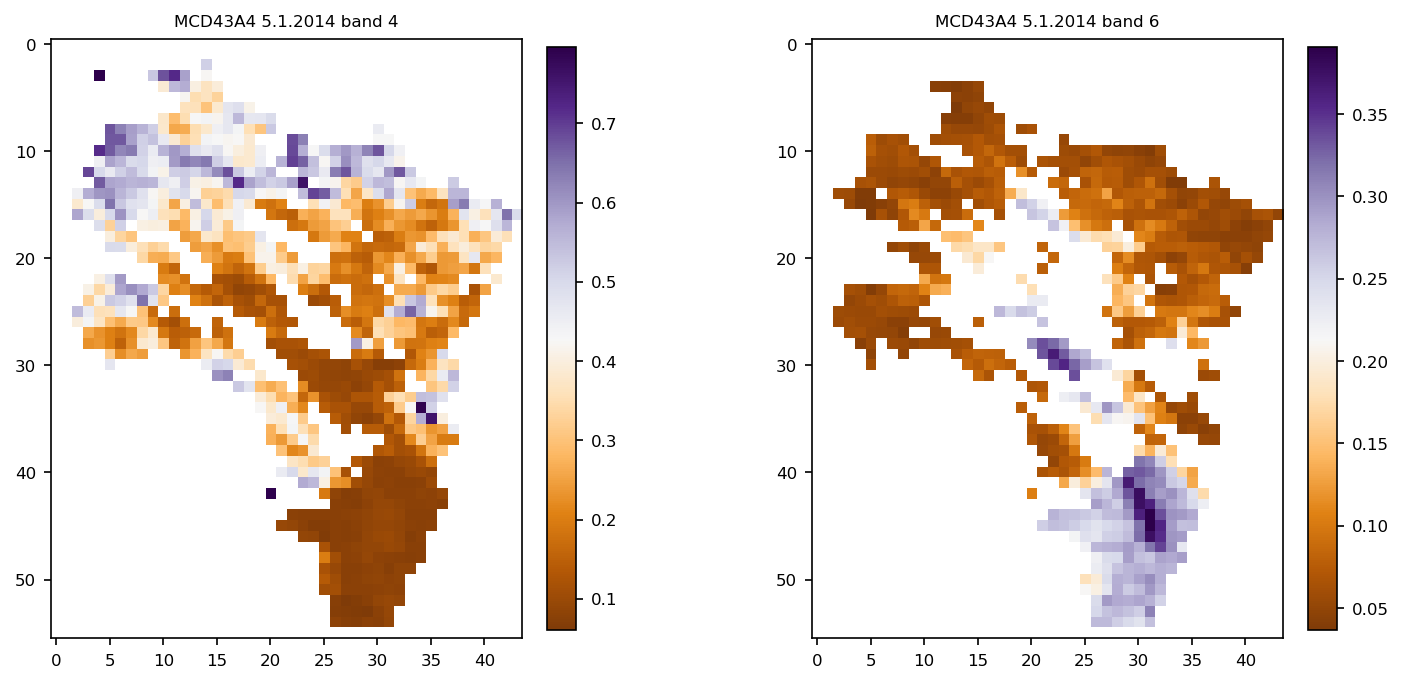

In [33]:
fig5 = plt.figure()
plt.figure(figsize=(12,18), dpi=150)

plt.subplot(3,2,1)
plt.title('MCD43A4 5.1.2014 band 4')
plt.imshow(B4_valuesMay1, cmap='PuOr')
plt.colorbar(fraction=0.046, pad=0.04)

plt.subplot(3,2,2)
plt.title('MCD43A4 5.1.2014 band 6')
plt.imshow(B6_valuesMay1, cmap='PuOr')
plt.colorbar(fraction=0.046, pad=0.04)

In [34]:
# The Normalized Difference Snow Index (NDSI)
NDSI1 = (B4_valuesMay1 - B6_valuesMay1) / (B4_valuesMay1 + B6_valuesMay1)

<Figure size 432x288 with 0 Axes>

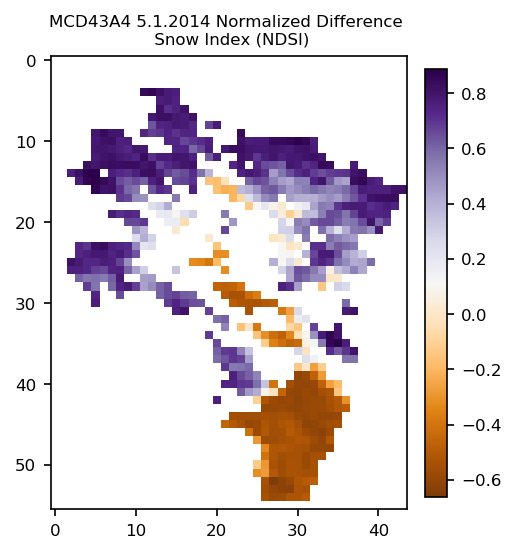

In [35]:
fig6 = plt.figure()
plt.figure(figsize=(4,4), dpi=150)
plt.title('MCD43A4 5.1.2014 Normalized Difference \n Snow Index (NDSI)')
plt.imshow(NDSI1, cmap='PuOr')
plt.colorbar(fraction=0.046, pad=0.04)
plt.show()

In [76]:
# Make a snow map
SnowMap3 = np.zeros((NDSI1.shape))

NO_DATA_const = -9999.0

NDSI_threshold = 0.4
SnowMap3[np.isnan(NDSI1)] = NO_DATA_const
SnowMap3[~np.isnan(NDSI1)] = NDSI1[~np.isnan(NDSI1)]
SnowMap3[(SnowMap3 >= NDSI_threshold) & (SnowMap3 != NO_DATA_const)] = 1.0
SnowMap3[(SnowMap3 < NDSI_threshold) & (SnowMap3 != NO_DATA_const)] = 0.0
SnowMap3[SnowMap3 == NO_DATA_const] = np.nan

<Figure size 432x288 with 0 Axes>

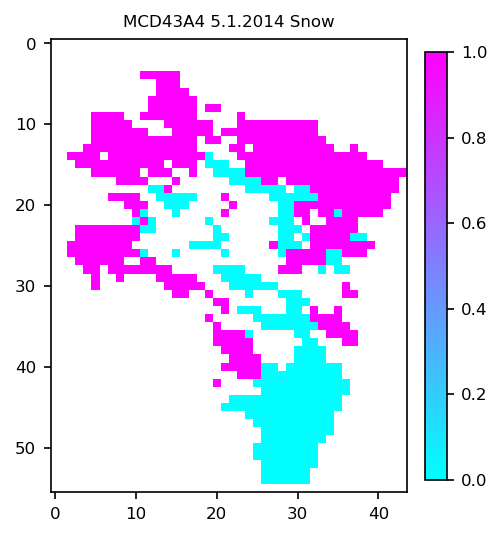

In [77]:
fig7 = plt.figure()
plt.figure(figsize=(4,4), dpi=150)
plt.title('MCD43A4 5.1.2014 Snow')
plt.imshow(SnowMap3, cmap='cool')
plt.colorbar(fraction=0.046, pad=0.04)
plt.show()

Pink = snow, Blue = no snow

### 6.15.2014 Data

In [38]:
plt.rc('font', size=8)
plt.rc('axes', titlesize=8)
plt.rc('axes', labelsize=8)
plt.rc('xtick',labelsize=8)
plt.rc('ytick',labelsize=8)
plt.rc('legend', fontsize=8)
plt.rc('figure', titlesize=8)

In [39]:
MCD_Band4_June15 = 'C:/Users/Allison and Brian/Documents/Research/MCD43A4_Data/6.15.2014/clip_MCD_6.15_band4_reproject.tif'
MCD_Band6_June15 = 'C:/Users/Allison and Brian/Documents/Research/MCD43A4_Data/6.15.2014/clip_MCD_6.15_band6_reproject.tif'

ds_band4June15 = gdal.Open(MCD_Band4_June15)   # Band number 4 for June 15
ds_band6June15 = gdal.Open(MCD_Band6_June15)   # Band number 6 for June 15


In [40]:
# Extract the pixel values
B4_valuesJune15 = ds_band4June15.ReadAsArray()
B6_valuesJune15 = ds_band6June15.ReadAsArray()

# Lets look at the shape of this data
print(B4_valuesJune15.shape)

(56, 44)


In [41]:
B4_valuesJune15 = B4_valuesJune15.astype(np.float64)
B6_valuesJune15 = B6_valuesJune15.astype(np.float64)

B4_valuesJune15[B4_valuesJune15 > 32766] = np.nan
B6_valuesJune15[B6_valuesJune15 > 32766] = np.nan

B4_valuesJune15 *= 0.000100
B6_valuesJune15 *= 0.000100

<Figure size 432x288 with 0 Axes>

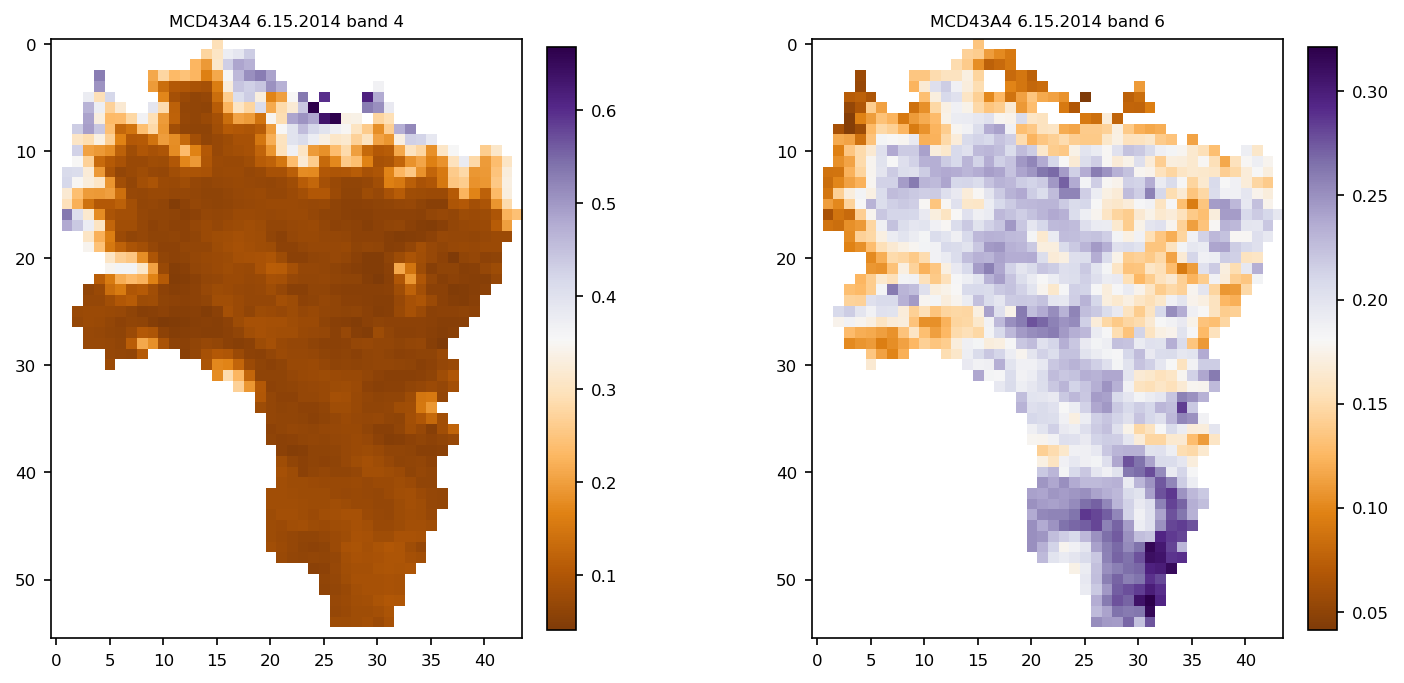

In [42]:
fig8 = plt.figure()
plt.figure(figsize=(12,18), dpi=150)

plt.subplot(3,2,1)
plt.title('MCD43A4 6.15.2014 band 4')
plt.imshow(B4_valuesJune15, cmap='PuOr')
plt.colorbar(fraction=0.046, pad=0.04)

plt.subplot(3,2,2)
plt.title('MCD43A4 6.15.2014 band 6')
plt.imshow(B6_valuesJune15, cmap='PuOr')
plt.colorbar(fraction=0.046, pad=0.04)

In [43]:
# The Normalized Difference Snow Index (NDSI)
NDSI2 = (B4_valuesJune15 - B6_valuesJune15) / (B4_valuesJune15 + B6_valuesJune15)

<Figure size 432x288 with 0 Axes>

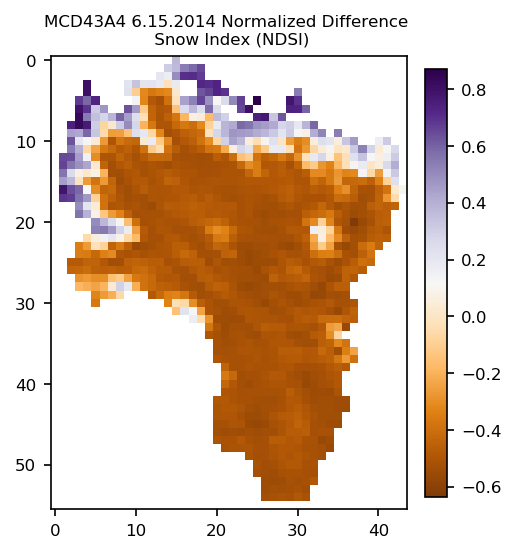

In [44]:
fig9 = plt.figure()
plt.figure(figsize=(4,4), dpi=150)
plt.title('MCD43A4 6.15.2014 Normalized Difference \n Snow Index (NDSI)')
plt.imshow(NDSI2, cmap='PuOr')
plt.colorbar(fraction=0.046, pad=0.04)
plt.show()

In [80]:
# Make a snow map
SnowMap4 = np.zeros((NDSI2.shape))

NO_DATA_const = -9999.0

NDSI_threshold = 0.4
SnowMap4[np.isnan(NDSI2)] = NO_DATA_const
SnowMap4[~np.isnan(NDSI2)] = NDSI2[~np.isnan(NDSI2)]
SnowMap4[(SnowMap4 >= NDSI_threshold) & (SnowMap4 != NO_DATA_const)] = 1.0
SnowMap4[(SnowMap4 < NDSI_threshold) & (SnowMap4 != NO_DATA_const)] = 0.0
SnowMap4[SnowMap4 == NO_DATA_const] = np.nan

<Figure size 432x288 with 0 Axes>

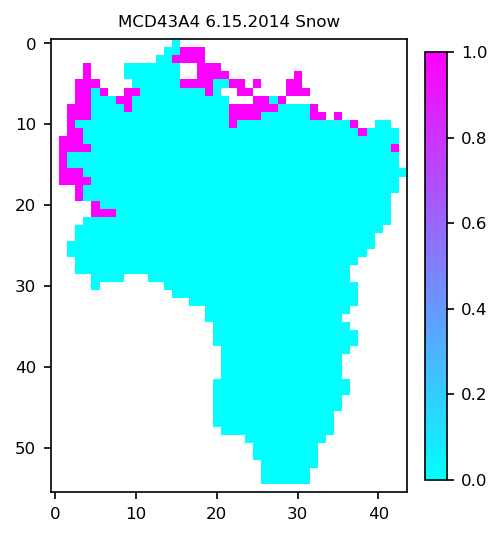

In [81]:
fig10 = plt.figure()
plt.figure(figsize=(4,4), dpi=150)
plt.title('MCD43A4 6.15.2014 Snow')
plt.imshow(SnowMap4, cmap='cool')
plt.colorbar(fraction=0.046, pad=0.04)
plt.show()

Pink = snow, Blue = no snow

# Results

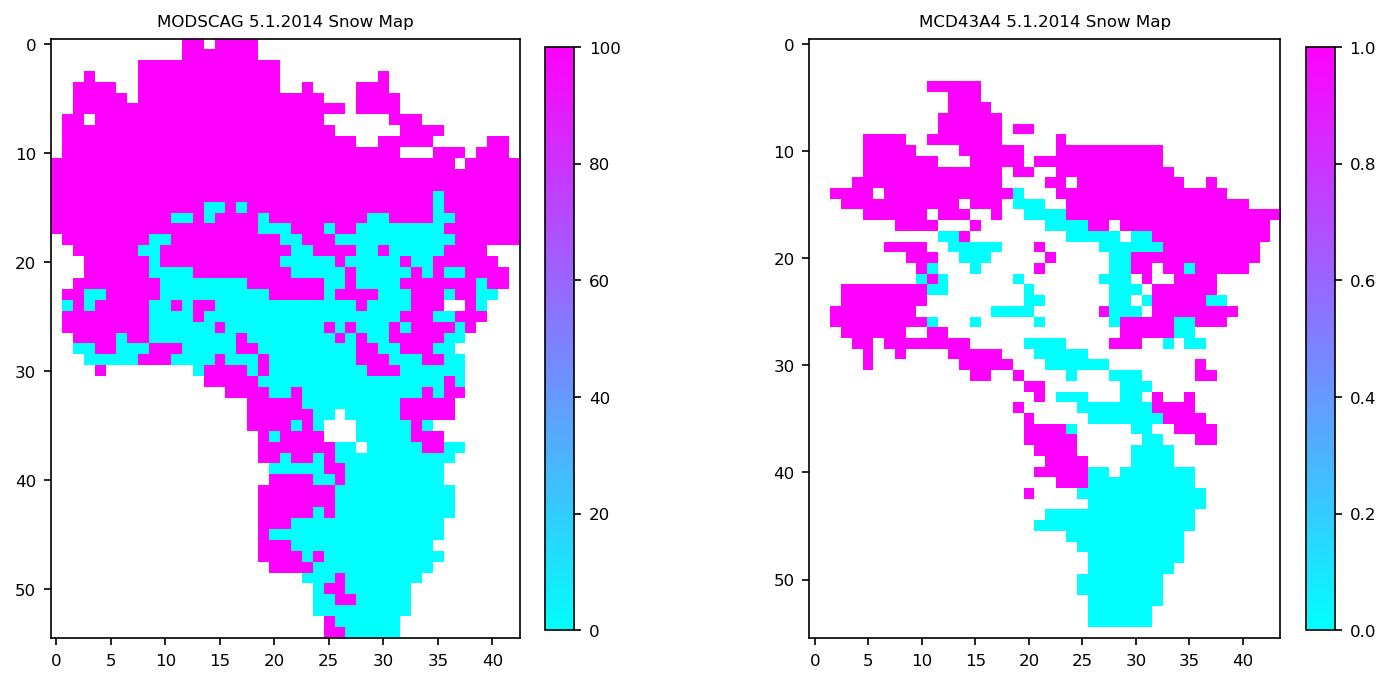

In [68]:
plt.figure(figsize=(12,18), dpi=150)

plt.subplot(3,2,1)
plt.title('MODSCAG 5.1.2014 Snow Map')
plt.imshow(SnowMap1, cmap='cool')
plt.colorbar(fraction=0.046, pad=0.04)

plt.subplot(3,2,2)
plt.title('MCD43A4 5.1.2014 Snow Map')
plt.imshow(SnowMap3, cmap='cool')
plt.colorbar(fraction=0.046, pad=0.04)

Pink = snow, Blue = no snow

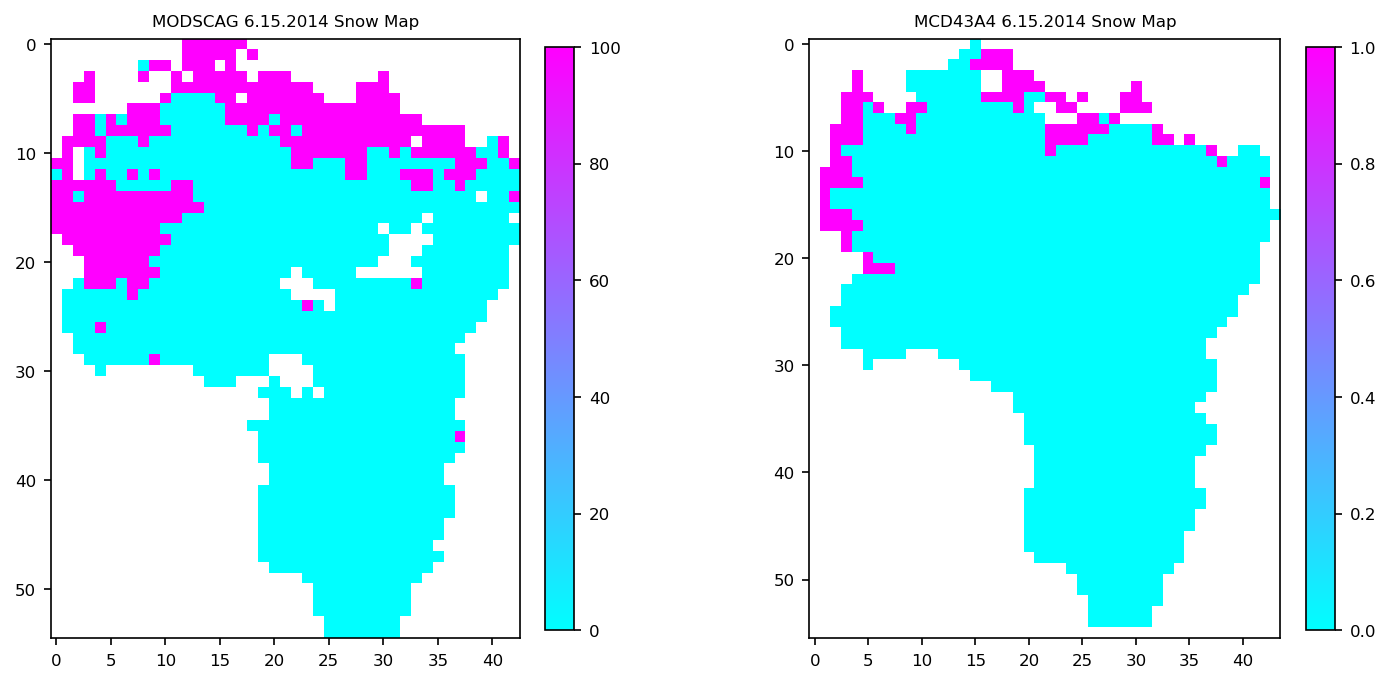

In [69]:
plt.figure(figsize=(12,18), dpi=150)

plt.subplot(3,2,1)
plt.title('MODSCAG 6.15.2014 Snow Map')
plt.imshow(SnowMap2, cmap='cool')
plt.colorbar(fraction=0.046, pad=0.04)

plt.subplot(3,2,2)
plt.title('MCD43A4 6.15.2014 Snow Map')
plt.imshow(SnowMap4, cmap='cool')
plt.colorbar(fraction=0.046, pad=0.04)

Pink = snow, Blue = no snow

To compare the amount of snow reported by each dataset, I made snow maps for both the MODSCAG snow fraction data and the MCD43A4 NDSI data. The snow map creates a simple snow/no snow binary figure for easy visual comparison. For the MCD43A4 data, a threshold value of 0.4 NDSI was used for classifying the presence of snow. Any value above 0.4 is displayed as snow, and any value below 0.4 is shown as no snow. This threshold value is commonly used in calculating SCA from NDSI data, as it has been found to represent snow cover most accurately and also does well in differentiating between snow cover and clouds (Hall et al., 1995). For the MODSCAG data, a snow fraction value of 40% was chosen as the threshold for classifying an area as snow covered. This value was chosen so that, like the NDSI data, only the top 60% of data would be used in analysis in an attempt to only look at areas where both algorithms were reasonably confident that snow cover was actually present on the ground. 

Looking at the data from 5.1.2014, we can see that the MODSCAG data is registering more snow cover overall than the NDSI from the MCD43A4. The top half of the watershed is almost completely covered, with scattered areas of snow stretching down all the way to the southern tip of the watershed. The MCD43A4 data display a much smaller snow-covered area, although it is worth noting that this image has a large area with no data values, particularly in the center and the far northern end of the watershed. By looking at the reflectance data, we can see that large areas of data in the center of the watershed are missing from Band 6, and in both Bands 4 and 6 there are large areas of data missing from the top of the watershed. This is not due to cloud cover, since the analysis dates were chosen specifically because they had a minimum amount of cloulds present, so the specific cause at this time is unknown. Much of the missing area should likely be snow covered since it occurs in the higher elevations. It is possible that a similar date with more complete data may present better results.

When we look at the data from 6.15.2014, we see that a large amount of melting has occured as we would expect during this time of the year. The remaining snow cover is largely isolated in the areas of higher elevation, though the two algorithms still differ in the extent of the snow cover. We can be fairly confident that the small areas of no data in the MODSCAG dataset area (due to minor cloud cover) are likely non-snow covered areas and would not change the overall amount of snow cover were they included. In contrast to the data from earlier in the season, the full extent of the watershed in represented in both datasets.

In general we can conclude that the MODSCAG algorithm tends to classify a greater amount of area as snow-covered than the NDSI algorithm calculated from basic reflectance band data with a 0.4 threshold value. The spectral libraries used in MODSCAG are clearly categorizing lower NDSI values as snow-cover. The study by Hall et al., 1995 claims that acceptably accurate values of snow cover have been found using NDSI threshold values as low as 0.25. This was implemented in this analysis, however the amount of snow-covered area added by lowering the threshold to this level was almost negligible. 

The next step is to compare these two MODIS datasets with a finer resolution dataset that can be used as "ground truth". This could be accomplished by using data from NASA's Landsat, which have a spatial resolution of 30m, but a temporal resolution of 16 days. Light Detection and Ranging (LiDAR) data, which can have a spatial resolution of 1m or less, is also a possibility for ground truthing. The most accurate MODIS dataset, once identified, can then assist in efforts to reconstruct historic snow-cover extent in an effort to quantify water delivery to the watershed and its downstream areas.



# References

Hall, D. K., Riggs, G. A., & Salomonson, V. V. (1995). Development of methods for mapping global snow cover using moderate resolution imaging spectroradiometer data. Remote Sensing of Environment, 54(2), 127–140. https://doi.org/10.1016/0034-4257(95)00137-P

National Climatic Data Center, NESDIS, NOAA, U.S. Department of Commerce. USDA/NRCS/NWCC SNOTEL Daily Data, Text Reports (DSI-6430). https://wcc.sc.egov.usda.gov/nwcc/site?sitenum=380

Painter, T. H., Rittger, K., McKenzie, C., Slaughter, P., Davis, R. E. & Dozier, J. (2009) Retrieval of subpixel snow covered area, grain size, and albedo from MODIS. Remote Sensing of Environment 113(4), 868–879. doi:10.1016/j.rse.2009.01.001. Data accessed online on 2018-10-20 at snow.jpl.nasa.gov.

Schaaf, C., Wang, Z. (2015). MCD43A4 MODIS/Terra+Aqua BRDF/Albedo Nadir BRDF Adjusted Ref Daily L3 Global - 500m V006 [Data set]. NASA EOSDIS Land Processes DAAC. doi: 10.5067/MODIS/MCD43A4.006